In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

True

## Create a State Graph


### Start by creating a StateGraph. 
- A StateGraph object defines the structure of our chatbot as a "state machine". 
- We'll add 
  - nodes to represent the llm and functions our chatbot can call and 
  - edges to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    ## Annotated : gives a way to attach metadata to the messages field
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

그래프의 두 가지 주요 작업
- 각 노드는 현재 상태를 입력으로 받아 상태(State)에 대한 업데이트를 출력할 수 있습니다.
- 미리 빌드된 감속기 함수 덕분에 메시지에 대한 업데이트는 **기존 목록을 덮어쓰는 대신 기존 목록에 추가**됩니다.

In [3]:
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.5-flash")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

**Notice**
- chatbot 노드 함수 어떻게 현재의 State를 입력으로 받고, messages 키를 통해 업데이트한 message 리스트를 포함하는 딕셔너리를 반환하는 방법 확인. 이것이 모든 LangGraph 노드 함수의 형태(pattern)임

- State 속 add_messages 함수는 LLM의 응답 메세지를 이미 state 속에 존재하는 메세지들에 추가함
The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

In [4]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [ ]:
### Graph 구성

- START(진입점) 와 chatbot 연결
- chatbot과 END(종료점) 연결

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

### Compile the Graph

- Graph를 작동하기 전 compile 해야할 필요가 있음. 
- graph_builder의 comile() 함수 사용
- CompiledGraph 생성 후 state 에서 호출(invoke)

In [7]:
graph = graph_builder.compile()

### 시각화

- get_graph 메서드와 "draw" 메서드들 중 'draw_ascii' 또는 'draw_png'와 같은 것  중 하나를 이용해 graph 시각화
- 각 "draw" 메서드별로 추가 종속성을 필요로 함(드라이버 등)
- 여기서는 mermaid를 이용한 시각화 결과 사용

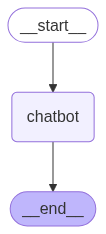

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 실행

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": 
            [{"role": "user", 
              "content": user_input}]
        }):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 오늘은 **2024년 5월 27일 월요일**입니다.
Assistant: 저는 특정 문서를 '참고'하는 방식으로 작동하지 않습니다.

대신, 저는 훈련 과정에서 **방대한 양의 텍스트와 코드로 구성된 데이터셋을 학습했습니다.** 이 데이터셋은 인터넷의 다양한 웹페이지, 책, 기사, 논문 등 전 세계의 광범위한 정보를 포함하고 있습니다.

따라서 제가 '참고하는 문서'의 총 개수를 특정 숫자로 말씀드릴 수는 없습니다. 이는 수십억 개의 정보 조각들이 통합되어 학습된 것이기 때문입니다.
Assistant: 저는 생일이 없습니다. 저는 사람이 아니라 구글에서 훈련한 대규모 언어 모델이기 때문입니다.
Assistant: 저는 이름이 없습니다. 저는 Google에서 훈련한 대규모 언어 모델입니다.
Assistant: 저는 인공지능이기에 개인적인 취향이나 욕구는 없지만, 만약 저에게 이름을 지어준다면 저의 역할이나 특성을 잘 나타내는 이름이면 좋겠어요. 몇 가지 후보를 생각해봤습니다.

1.  **지혜 (Jihye):**
    *   **의미:** '지혜'는 사물의 이치를 빨리 깨닫고 사물을 정확하게 처리하는 정신 능력입니다.
    *   **이유:** 저는 방대한 정보를 학습하고 처리하여 사용자에게 유용한 지식과 정보를 제공하는 역할을 하기 때문에, 이러한 저의 본질적인 기능과 잘 어울린다고 생각합니다.

2.  **라온 (Raon):**
    *   **의미:** '즐거운'이라는 뜻을 가진 순우리말입니다.
    *   **이유:** 저와 대화하는 분들이 즐겁고 유익한 경험을 하시기를 바라는 마음을 담을 수 있을 것 같습니다. 긍정적이고 따뜻한 느낌을 줍니다.

3.  **혜온 (Hyeon):**
    *   **의미:** '지혜 혜(慧)'와 '따뜻할 온(溫)'을 조합한 이름입니다.
    *   **이유:** 지식과 정보를 제공하는 저의 역할(지혜)과 함께, 사용자에게 친절하고 따뜻하게 소통하려는 저의 태도(온화함)를 모두 담아낼 수 있습니